In [ ]:
import numpy as np
from numpy import loadtxt
from google.colab import drive
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import scipy.io

In [ ]:
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive


Deep learning model attempting to mimic part of the EEG data cleaning process performed in the lab. Input is 3D time series, where each dimension is a channel of EEG recording from a random time and channel from a given participant after they consumed either psilocybin or placebo. First, a 1-D convolutional layer with shared filters across all 3 dimensions attempts to identify which of the 3 input channels would result in best classification performance. Then, an LSTM model predicts state of intoxication separately for each channel, and weights these 3 predictions using a softmax of the convolutional channel selection output. 

In [ ]:
def loadData():
  matdata = scipy.io.loadmat("PsiloClassifier/dataSplit/trainX3.mat")
  trainX = matdata['trainX']
  matdata = scipy.io.loadmat("PsiloClassifier/dataSplit/trainY3.mat")
  trainY = matdata['trainY']
  matdata = scipy.io.loadmat("PsiloClassifier/dataSplit/valX3.mat")
  valX = matdata['valX']
  matdata = scipy.io.loadmat("PsiloClassifier/dataSplit/valY3.mat")
  valY = matdata['valY']
  #matdata = scipy.io.loadmat("PsiloClassifier/dataSplit/testX3.mat")
  #testX = matdata['testX']
  #matdata = scipy.io.loadmat("PsiloClassifier/dataSplit/testY3.mat")
  #testY = matdata['testY']

  trainX = trainX.astype('float32')
  valX = valX.astype('float32')
  trainY = trainY.astype('float32').reshape((-1,1))
  valY = valY.astype('float32').reshape((-1,1))
  
  shape = trainX.shape
  samples = shape[0]
  timesteps = shape[1]
  trainX_0 = trainX[:, :, 0].reshape(samples, 1, timesteps)
  trainX_1 = trainX[:, :, 1].reshape(samples, 1, timesteps)
  trainX_2 = trainX[:, :, 2].reshape(samples, 1, timesteps)
  
  shape = valX.shape
  samples = shape[0]
  timesteps = shape[1]
  valX_0 = valX[:, :, 0].reshape(samples, 1, timesteps)
  valX_1 = valX[:, :, 0].reshape(samples, 1, timesteps)
  valX_2 = valX[:, :, 0].reshape(samples, 1, timesteps)

  trainX_0 = torch.tensor(trainX_0)
  trainX_1 = torch.tensor(trainX_1)
  trainX_2 = torch.tensor(trainX_2)
  trainY = torch.tensor(trainY)
  valX_0 = torch.tensor(valX_0)
  valX_1 = torch.tensor(valX_1)
  valX_2 = torch.tensor(valX_2)
  valY = torch.tensor(valY)

  return (trainX_0, trainX_1, trainX_2), trainY, (valX_0, valX_1, valX_2), valY;

In [ ]:
def createDataset(trainX, trainY, valX, valY):
  train_ds = TensorDataset(trainX[0], trainX[1], trainX[2], trainY)
  val_ds = TensorDataset(valX[0], valX[1], valX[2], valY)
  return train_ds, val_ds

In [ ]:
def createDataLoaders(train_ds, val_ds, bs):
  train_dl = DataLoader(train_ds, bs, shuffle=False)
  val_dl = DataLoader(val_ds, bs, shuffle=False)
  return train_dl, val_dl

In [ ]:
sigmoid = nn.Sigmoid()
softmax = nn.Softmax(1)
criterion = nn.BCELoss()

def c_out_length(in_length, kernel_size, padding=0, dilation=1, stride=1):
  length_out = ((in_length + 2*padding - dilation*(kernel_size - 1) - 1) / stride ) + 1
  return length_out

class CleaningClassifier(nn.Module):
  def __init__(self, sample_length, num_filters, kernel_size, pool_kernel_size, output_dim):
    super().__init__()
    self.sample_length = sample_length
    self.num_filters = num_filters
    self.pool_kernel_size = pool_kernel_size

    self.cleaning_conv = nn.Conv1d(1, num_filters, kernel_size)
    self.cleaning_pool = nn.MaxPool1d(pool_kernel_size)
    self.sample_choice = torch.zeros(3)
    
    conv_out_length = c_out_length(sample_length, kernel_size)
    pool_out_length = int(conv_out_length/pool_kernel_size)
    fully_connected_input = int(pool_out_length * num_filters)
    self.fc_input = fully_connected_input
    self.fc = nn.Linear(fully_connected_input, output_dim)

    hidden_dim = 60
    num_lstm_layers = 1
    input_dim = 1
    self.hidden_dim = hidden_dim
    self.num_lstm_layers = num_lstm_layers
    self.rnn = nn.LSTM(input_dim, hidden_dim, num_lstm_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, 16)
    self.fc2 = nn.Linear(16, output_dim)
  
  def init_hidden(self, x):
    h0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_dim).to(device)
    c0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_dim).to(device)
    return h0, c0

  def forward(self, c1, c2, c3):
    c1_choice = self.cleaning_conv(c1)
    c1_choice = self.cleaning_pool(c1_choice)
    c1_choice = c1_choice.view(-1, self.fc_input)
    c1_choice = self.fc(c1_choice)

    c2_choice = self.cleaning_conv(c2)
    c2_choice = self.cleaning_pool(c2_choice)
    c2_choice = c2_choice.view(-1, self.fc_input)
    c2_choice = self.fc(c2_choice)

    c3_choice = self.cleaning_conv(c3)
    c3_choice = self.cleaning_pool(c3_choice)
    c3_choice = c3_choice.view(-1, self.fc_input)
    c3_choice = self.fc(c3_choice)
    
    sample_choice = torch.cat((c1_choice, c2_choice, c3_choice), 1)
    sample_choice = softmax(sample_choice)

    c1 = c1.permute(0,2,1)
    c2 = c2.permute(0,2,1)
    c3 = c3.permute(0,2,1)

    h0, c0 = self.init_hidden(c1)
    out, (hn, cn) = self.rnn(c1, (h0, c0))
    out = self.fc1(out[:, -1, :])
    out = self.fc2(out)
    combined_output = out * torch.reshape(sample_choice[:, 0], (-1, 1))

    h0, c0 = self.init_hidden(c2)
    out, (hn, cn) = self.rnn(c2, (h0, c0))
    out = self.fc1(out[:, -1, :])
    out = self.fc2(out)
    combined_output += out * torch.reshape(sample_choice[:, 1], (-1, 1))

    h0, c0 = self.init_hidden(c3)
    out, (hn, cn) = self.rnn(c3, (h0, c0))
    out = self.fc1(out[:, -1, :])
    out = self.fc2(out)
    combined_output += out * torch.reshape(sample_choice[:, 2], (-1, 1))

    combined_output = sigmoid(combined_output)

    return combined_output

def accuracyAndLoss(data_loader, model):
  total, correct, loss, batches = 0, 0, 0, 0
  model.eval()
  for c1, c2, c3, y in data_loader:
    c1 = c1.to(device)
    c2 = c2.to(device)
    c3 = c3.to(device)
    y = y.to(device)
    out = model(c1, c2, c3)
    preds = out.round()
    total += y.size(0)
    batches += 1
    correct += (preds == y).sum().item()
    loss += criterion(out, y)
  return correct/total, loss/batches

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainX, trainY, valX, valY = loadData()
train_ds, val_ds = createDataset(trainX, trainY, valX, valY)
train_dl, val_dl = createDataLoaders(train_ds, val_ds, bs=512)

In [ ]:
def train_model(lr, epochs, sample_length, num_filters, kernel_size, pool_kernel_size, plot=False):
  model = CleaningClassifier(sample_length, num_filters, kernel_size, pool_kernel_size, 1).to(device)
  criterion = nn.BCELoss()
  opt = torch.optim.RMSprop(model.parameters(), lr=lr)
  train_accuracy = []
  val_accuracy = []
  train_loss = []
  val_loss = []

  print('Starting model training... lr:', lr, ' epochs:', epochs,  ' num_filters:', num_filters, ' kernel_size:', kernel_size, ' pool_kernel_size:', pool_kernel_size)

  for epoch in range(epochs):
      for i, (c1_batch, c2_batch, c3_batch, y_batch) in enumerate(train_dl):
          model.train()
          opt.zero_grad()
          c1_batch = c1_batch.to(device)
          c2_batch = c2_batch.to(device)
          c3_batch = c3_batch.to(device)
          y_batch = y_batch.to(device)
          out = model(c1_batch, c2_batch, c3_batch)
          loss = criterion(out, y_batch)
          loss.backward()
          opt.step()
      
      with torch.no_grad():
        train_accuracy_, train_loss_ = accuracyAndLoss(train_dl, model)
        train_accuracy.append(train_accuracy_)
        train_loss.append(train_loss_)
        val_accuracy_, val_loss_ = accuracyAndLoss(val_dl, model)
        val_accuracy.append(val_accuracy_)
        val_loss.append(val_loss_)

      print('Epoch ' , epoch , '... train_accuracy:', round(train_accuracy[-1], 3), ' val_accuracy:', round(val_accuracy[-1], 3), ' train_loss:', round(train_loss[-1].item(), 3), ' val_loss:', round(val_loss[-1].item(), 3) )

  if plot == True: 
    plt.subplot(2,1,1)
    plt.plot(train_accuracy, 'b')
    plt.title("accuracy")
    plt.plot(val_accuracy, 'r')

    plt.subplot(2,1,2)
    plt.plot(train_loss, 'b')
    plt.title("loss")
    plt.plot(val_loss, 'r')

    plt.tight_layout()
    plt.show()

  print('Training complete! train_accuracy:', round(train_accuracy[-1], 3), ' val_accuracy:', round(val_accuracy[-1], 3), ' train_loss:', round(train_loss[-1].item(), 3), ' val_loss:', round(val_loss[-1].item(), 3) )

  return train_accuracy, val_accuracy, train_loss, val_loss, model;

Starting model training... lr: 0.001  epochs: 80  num_filters: 5  kernel_size: 30  pool_kernel_size: 50
Epoch  0 ... train_accuracy: 0.618  val_accuracy: 0.53  train_loss: 0.648  val_loss: 0.747
Epoch  1 ... train_accuracy: 0.571  val_accuracy: 0.514  train_loss: 0.673  val_loss: 0.706
Epoch  2 ... train_accuracy: 0.619  val_accuracy: 0.53  train_loss: 0.651  val_loss: 0.783
Epoch  3 ... train_accuracy: 0.605  val_accuracy: 0.517  train_loss: 0.657  val_loss: 0.776
Epoch  4 ... train_accuracy: 0.619  val_accuracy: 0.52  train_loss: 0.649  val_loss: 0.769
Epoch  5 ... train_accuracy: 0.555  val_accuracy: 0.499  train_loss: 0.683  val_loss: 0.702
Epoch  6 ... train_accuracy: 0.613  val_accuracy: 0.523  train_loss: 0.66  val_loss: 0.72
Epoch  7 ... train_accuracy: 0.506  val_accuracy: 0.494  train_loss: 0.694  val_loss: 0.699
Epoch  8 ... train_accuracy: 0.519  val_accuracy: 0.492  train_loss: 0.692  val_loss: 0.696
Epoch  9 ... train_accuracy: 0.532  val_accuracy: 0.493  train_loss: 0.68

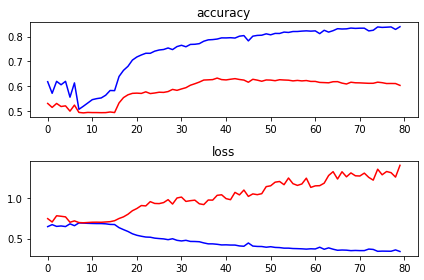

Training complete! train_accuracy: 0.84  val_accuracy: 0.603  train_loss: 0.342  val_loss: 1.405


In [ ]:
a, b, c, d, model = train_model(0.001, 80, 250, 5, 30, 50, True)

Starting model training... lr: 0.001  epochs: 80  num_filters: 5  kernel_size: 80  pool_kernel_size: 40
Epoch  0 ... train_accuracy: 0.587  val_accuracy: 0.535  train_loss: 0.67  val_loss: 0.699
Epoch  1 ... train_accuracy: 0.593  val_accuracy: 0.51  train_loss: 0.674  val_loss: 0.702
Epoch  2 ... train_accuracy: 0.625  val_accuracy: 0.529  train_loss: 0.646  val_loss: 0.778
Epoch  3 ... train_accuracy: 0.653  val_accuracy: 0.556  train_loss: 0.626  val_loss: 0.774
Epoch  4 ... train_accuracy: 0.563  val_accuracy: 0.498  train_loss: 0.681  val_loss: 0.703
Epoch  5 ... train_accuracy: 0.535  val_accuracy: 0.49  train_loss: 0.688  val_loss: 0.701
Epoch  6 ... train_accuracy: 0.552  val_accuracy: 0.503  train_loss: 0.684  val_loss: 0.704
Epoch  7 ... train_accuracy: 0.55  val_accuracy: 0.5  train_loss: 0.685  val_loss: 0.704
Epoch  8 ... train_accuracy: 0.577  val_accuracy: 0.512  train_loss: 0.67  val_loss: 0.72
Epoch  9 ... train_accuracy: 0.647  val_accuracy: 0.549  train_loss: 0.629  

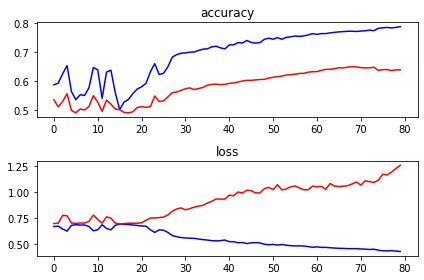

Training complete! train_accuracy: 0.788  val_accuracy: 0.638  train_loss: 0.431  val_loss: 1.258


In [ ]:
a, b, c, d, model = train_model(0.001, 80, 250, 5, 80, 40, True)